In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt  

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport

/Users/shaan/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [6]:
train_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/train.csv" )
train_orig=pd.DataFrame(train_orig)
Y_train=train_orig["SalePrice"]
train=train_orig.drop(['SalePrice'],axis=1)
test_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/test.csv" )
test_orig=pd.DataFrame(test_orig)

In [7]:
#cleaning
def cleanCat(categoricalData):
    categoricalData["MSZoning"].replace('C (all)', 'C',inplace=True)
    categoricalData["Alley"].replace(np.nan, 'NA',inplace=True)
    categoricalData["MasVnrType"].replace(np.nan, 'None',inplace=True)#CHECK THIS
    categoricalData.replace(np.nan, 'NA',inplace=True)
    categoricalData["Exterior2nd"].replace('CmentBd', 'CemntBd',inplace=True)
    categoricalData["Exterior2nd"].replace('Brk Cmn', 'BrkComm',inplace=True)
    categoricalData["Exterior2nd"].replace('Wd Shng', 'WdShing',inplace=True)
    return categoricalData

In [8]:
#encode
def encodeCat(categoricalData):
    categoricalData=cleanCat(categoricalData)
    encodedCategoricalData=pd.get_dummies(categoricalData)
    return encodedCategoricalData

In [9]:
#process numerical data
def processNonCat(nonCategoricalData, testFlag, averageYears):
    lowerLimitFor0Years = -100
    
    nonCategoricalData=nonCategoricalData.drop(['Id'],axis=1)
    nonCategoricalData.replace(np.nan, 0,inplace=True)#How to handle zeros
    yearCols=['YrSold','YearBuilt','YearRemodAdd','MoSold','GarageYrBlt']    
    if(testFlag==False):
        averageYears = np.floor(np.average(nonCategoricalData[yearCols],axis=0))
    nonCategoricalData[yearCols]=nonCategoricalData[yearCols]- averageYears
    nonCategoricalData[yearCols]=np.maximum(nonCategoricalData[yearCols], lowerLimitFor0Years)
    print("using below averages:")
    print(averageYears)
    areaCols=['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
    #TotalBsmtSF = type1 + type2 + unfin (check)
    for col in areaCols:
        nonCategoricalData[col]=np.log(nonCategoricalData[col]+10)-np.log(10)

    nonCategoricalData['MiscVal']=np.log(nonCategoricalData['MiscVal']+10)-np.log(10)
    return nonCategoricalData, averageYears

In [10]:
def scale_nonCat(nonCategoricalData, testflag, scaler):
    names = nonCategoricalData.columns
    if(testflag==False):
        scaler = preprocessing.StandardScaler()
        nonCategoricalData = scaler.fit_transform(nonCategoricalData)
    else:
        nonCategoricalData = scaler.transform(nonCategoricalData)
    nonCategoricalData=pd.DataFrame(nonCategoricalData, columns=names)
    return nonCategoricalData,scaler

In [11]:
def processData(train, averageYears,scaler):
    categoricalData=train.select_dtypes(include='object').copy()
    nonCategoricalData=train.select_dtypes(exclude='object').copy()
    encodedCategoricalData=encodeCat(categoricalData)
    if( type(averageYears) == type(0) ):
        nonCategoricalData, averageYears = processNonCat(nonCategoricalData,False, 0)
        #nonCategoricalData, scaler = scale_nonCat(nonCategoricalData,False, 0)
    else:
        nonCategoricalData, _ = processNonCat(nonCategoricalData,True,averageYears)
        #nonCategoricalData, _ = scale_nonCat(nonCategoricalData,True,scaler)

    nonCategoricalData=pd.concat([nonCategoricalData,encodedCategoricalData],axis=1)
    return nonCategoricalData, averageYears, scaler

In [12]:
def sameSchema(X_train,X_test_orig):    
    #make sure the columns are the same and in same order
    for col in X_train.columns:
        if col not in X_test_orig.columns:
            X_test_orig[col]=np.zeros(X_test_orig.shape[0])
    X_test_orig=X_test_orig[X_train.columns]
    return X_test_orig

In [13]:
X_train_processed, averageYears,scaler = processData(train, 0,0)
test_orig_processed, _,_ = processData(test_orig, averageYears,scaler)
test_orig_processed = sameSchema(X_train_processed,test_orig_processed)

using below averages:
[2007. 1971. 1984.    6. 1868.]
using below averages:
[2007. 1971. 1984.    6. 1868.]


In [14]:
#trasnform Y
Y_train_processed = Y_train
#Y_train_processed = np.log(Y_train)

In [146]:
#split into test and train
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_train_processed, Y_train_processed, test_size=0.1, random_state=0)
print("X_train_ shape = ", X_train_.shape)
print("Y_train_ shape = ", Y_train_.shape)
print("X_test_ shape = ", X_test_.shape)

X_train_ shape =  (1314, 303)
Y_train_ shape =  (1314,)
X_test_ shape =  (146, 303)


In [147]:
#remove zero columns from train and the respective columns from test
X_train_ = X_train_.loc[:, (X_train_ != 0).any(axis=0)]
print("X_train shape after removing zeros = ", X_train_.shape)
#remove these columns from other datasets
X_test_=X_test_[X_train_.columns]
test_orig_processed=test_orig_processed[X_train_.columns]

print("X_train_ shape after removing zeros = ", X_train_.shape)
print("X_test_ shape after removing zeros = ", X_test_.shape)
print("test_orig_processed shape after removing zeros = ", test_orig_processed.shape)

X_train shape after removing zeros =  (1314, 302)
X_train_ shape after removing zeros =  (1314, 302)
X_test_ shape after removing zeros =  (146, 302)
test_orig_processed shape after removing zeros =  (1459, 302)


In [148]:
def remove_corr(X_train_,X_test_,test_orig_processed):
    corr_matrix = X_train_.corr().abs()
    #sns.heatmap(corr_matrix,vmin=-1, vmax=1, center= 0)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
    #print(to_drop)
    
    #drop high corr columns
    X_train_=X_train_.drop(to_drop,axis=1)
    #X_test=X_test.drop(to_drop,axis=1)
    X_test_=X_test_.drop(to_drop,axis=1)
    test_orig_processed=test_orig_processed.drop(to_drop,axis=1)
    
    #print("X_train_ shape after removing corr var = ", X_train_.shape)
    #print("X_test_ shape after removing corr var = ", X_test_.shape)
    #print("test_orig_processed shape after corr var = ", test_orig_processed.shape)
    return X_train_,X_test_,test_orig_processed

In [149]:
def remove_colsWithZeros(X_train_,X_test_,test_orig_processed):
    percent0 = np.sum(X_train_==0,axis=0)/len(X_train_)
    colsToKeep=[i for i in percent0.index if percent0[i]<0.999]
    return X_train_[colsToKeep],X_test_[colsToKeep],test_orig_processed[colsToKeep]

In [150]:
def standardizeX(X_train_,X_test_,test_orig_processed):
    names = X_train_.columns
    scaler = preprocessing.StandardScaler()
    X_train_ = scaler.fit_transform(X_train_)
    X_test_ = scaler.transform(X_test_)
    test_orig_processed = scaler.transform(test_orig_processed)

    X_train_=pd.DataFrame(X_train_, columns=names)
    X_test_=pd.DataFrame(X_test_, columns=names)
    test_orig_processed=pd.DataFrame(test_orig_processed, columns=names)
    return X_train_,X_test_,test_orig_processed

In [151]:
def standardizeY(Y_train_,Y_test_):
    avg = np.average(Y_train_)
    std = np.std(Y_train_)
    Y_train_=(Y_train_-avg)/std
    Y_test_=(Y_test_-avg)/std

    return Y_train_,Y_test_

In [152]:
#nonCategoricalData=train.select_dtypes(exclude='object').copy()
#nonCategoricalData, averageYears = processNonCat(nonCategoricalData,False, 0)
#profile = ProfileReport(nonCategoricalData, title='Pandas Profiling Report', html={'style':{'full_width':True}})
#profile.to_file(output_file="nonCategorical.html")



In [153]:
def printErrors(Y_train,Y_pred):
    print('Root Mean Squared Log Error:', round(np.sqrt(metrics.mean_squared_error(np.log(Y_train), np.log(Y_pred))),3))
    print('Mean % error:',round(np.sqrt(metrics.mean_squared_error((Y_train), (Y_pred)))/np.average((Y_pred))*100,2))

In [154]:
def saveOutput(y_pred):
    y_pred_df=pd.DataFrame()
    y_pred_df["Id"]=range(1461,1461+len(y_pred),1)
    y_pred_df["SalePrice"]=y_pred
    file = "/Users/shaan/Downloads/DataSet/my_submission.csv"
    y_pred_df.to_csv(file,index=False)
    print("saved to file :"+file)

In [155]:
def residualPlot(pred,actual):
    residual = pred - actual
    sns.scatterplot(x=actual,y=residual)

In [156]:
#model1
def linear_reg(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    regressor = LinearRegression()  
    regressor.fit(X_train_, Y_train_)
    print("------Simple linear regression model---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred=np.maximum(Y_pred,1)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.maximum(Y_pred,1)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(regressor.predict(test_orig_processed))
    return regressor

In [157]:
#model2
#same with logarithmic Y
def linear_reg_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = LinearRegression()  
    regressor.fit(X_train_, Y_train_exp)
    print("------Simple linear regression model with log---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(np.exp(regressor.predict(test_orig_processed)))
    return regressor

In [158]:
#model3
#same with logarithmic Y
def ols_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    #X_train_,X_test_,test_orig_processed = remove_colsWithZeros(X_train_,X_test_,test_orig_processed)
    X_train_,X_test_,test_orig_processed = remove_corr(X_train_,X_test_,test_orig_processed)
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = LinearRegression()  
    regressor = sm.OLS(Y_train_exp, X_train_).fit()
    print("------OLS model with log---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(regressor.predict(test_orig_processed))
    return regressor

In [159]:
def removeYOutliers(X_train_,Y_train_):
    avg=np.average(Y_train_)
    std=np.std(Y_train_)
    filterval=avg+6*std
    orig_index=Y_train_[Y_train_.loc[:]<=filterval].index
    indexes = np.array(orig_index)
    Y_train_ =[y for y in Y_train_ if y <= filterval]
    Y_train_=pd.Series(Y_train_,orig_index)
    X_train_=X_train_.loc[indexes,:]
    return X_train_,Y_train_

In [160]:
def removeOutliersX(X_train_,Y_train_):
    cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
    data=X_train_[cols]
    avg=np.average(data)
    std=np.std(data)
    filterval=avg+4*std
    indexes=[]
    for i in range(len(cols)):
        col=cols[i]
        indexes=np.concatenate((indexes,data[data[col]<=filterval[i]].index.values))
    Y_train_=Y_train_[indexes]
    X_train_=X_train_.loc[indexes,:]
    return X_train_,Y_train_

In [161]:
#model4
#same with logarithmic Y
def ols_withscale(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    #X_train_,X_test_,test_orig_processed = remove_colsWithZeros(X_train_,X_test_,test_orig_processed)
    #X_train_,X_test_,test_orig_processed = standardizeX(X_train_,X_test_,test_orig_processed)
    #Y_train_, Y_test_ = standardizeY(Y_train_, Y_test_)
    X_train_,X_test_,test_orig_processed = remove_corr(X_train_,X_test_,test_orig_processed)
    
    X_train_,Y_train_=removeYOutliers(X_train_,Y_train_)
    X_train_,Y_train_=removeOutliersX(X_train_,Y_train_)
    Y_train_exp=np.log(Y_train_)


    regressor = LinearRegression()  
    regressor = sm.OLS(Y_train_exp, X_train_).fit()
    print("------OLS model outliers removed---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(np.exp(regressor.predict(test_orig_processed)))
    return regressor

In [162]:
#model5
#same with logarithmic Y
def rfmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    #X_train_,X_test_,test_orig_processed = remove_colsWithZeros(X_train_,X_test_,test_orig_processed)
    #X_train_,X_test_,test_orig_processed = standardizeX(X_train_,X_test_,test_orig_processed)
    #Y_train_, Y_test_ = standardizeY(Y_train_, Y_test_)
    X_train_,X_test_,test_orig_processed = remove_corr(X_train_,X_test_,test_orig_processed)
    
    #X_train_,Y_train_=removeYOutliers(X_train_,Y_train_)
    Y_train_exp=np.log(Y_train_)
    
    rf = RandomForestRegressor(n_estimators = 1000,warm_start=True)
    rf.fit(X_train_, Y_train_exp)
    print("------random forest---------")
    print("Train Errors-")
    Y_pred=rf.predict(X_train_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=rf.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(np.exp(rf.predict(test_orig_processed)))
    return rf

In [163]:
#model6
def lasso(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    #X_train_,X_test_,test_orig_processed = remove_colsWithZeros(X_train_,X_test_,test_orig_processed)
    #X_train_,X_test_,test_orig_processed = standardizeX(X_train_,X_test_,test_orig_processed)
    #Y_train_, Y_test_ = standardizeY(Y_train_, Y_test_)
    #X_train_,X_test_,test_orig_processed = remove_corr(X_train_,X_test_,test_orig_processed)
    
    X_train_,Y_train_=removeYOutliers(X_train_,Y_train_)
    Y_train_exp=np.log(Y_train_)
    lasso=linear_model.ElasticNet( random_state=0,l1_ratio=2)
    lasso.fit(X_train_, Y_train_exp)
    print("------lasso---------")
    print("Train Errors-")
    Y_pred=lasso.predict(X_train_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    print("Test Errors-")
    Y_pred=lasso.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(np.exp(lasso.predict(test_orig_processed)))
    return lasso

In [164]:
type((np.double(X_train_.values)))

numpy.ndarray

In [216]:
#model7
def nnmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    #X_train_,X_test_,test_orig_processed = remove_colsWithZeros(X_train_,X_test_,test_orig_processed)
    #X_train_,X_test_,test_orig_processed = standardizeX(X_train_,X_test_,test_orig_processed)
    #Y_train_, Y_test_ = standardizeY(Y_train_, Y_test_)
    #X_train_,X_test_,test_orig_processed = remove_corr(X_train_,X_test_,test_orig_processed)
    
    X_train_,Y_train_=removeYOutliers(X_train_,Y_train_)
    X_train_,Y_train_=removeOutliersX(X_train_,Y_train_)

    Y_train_exp=np.log(Y_train_)
    Y_train_exp = [[y] for y in Y_train_exp]
    y_test=np.log(Y_test_)
    y_test = [[y] for y in y_test]
    
    #dimensions
    batch,dim,hidden,out = int(X_train_.shape[0]),int(X_train_.shape[1]),int(X_train_.shape[1]/10),1
    hidden=256
    #create input output tensors
    x = torch.tensor(X_train_.values)
    y = torch.tensor(Y_train_exp)
    y_test = torch.tensor(y_test)
    lr = 1e-4
    epochs = 8901
    
    model = torch.nn.Sequential(
        torch.nn.Linear(dim, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, math.floor(hidden/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(math.floor(hidden/2), hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden,out),
    )
    model=model.float()
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss =[]
    test_loss = []
    for i in range(epochs):
        pred=model(x.float())
        loss = loss_fn(pred,y.float())
        if i%1000==0:
            print(i,loss.item())
            train_loss.append([i,loss.item()])
            test_loss.append([i,loss_fn(model(torch.tensor(X_test_.values).float()),y_test.float()).item()])
    
        #reset gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print("------neural net 1hidden---------")
    print("Train Errors-")
    predy=model(x.float())
    Y_pred=predy.detach().numpy()    
    Y_pred=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred)
    #sns.scatterplot(pred-y.detach().numpy(),y.detach().numpy())
    print("Test Errors-")
    Y_pred=model(torch.tensor(X_test_.values).float())
    Y_pred=Y_pred.detach().numpy()    
    Y_pred=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        pred = model(torch.tensor(test_orig_processed.values).float())
        pred = pred.detach().numpy()
        pred=np.exp(pred)
        saveOutput(pred)
    return model,train_loss, test_loss,predy,y

In [217]:
linReg = linear_reg(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, False)
linRegLog = linear_reg_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, False)
olsLog = ols_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, False)
olsLog1 = ols_withscale(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, False)
#rf = rfmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, False)
#lasso = lasso(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, True)
nnmod, train_loss, test_loss, pred,y = nnmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, True)

------Simple linear regression model---------
Train Errors-
Root Mean Squared Log Error: 0.121
Mean % error: 11.59
Test Errors-
Root Mean Squared Log Error: 0.212
Mean % error: 20.78
------Simple linear regression model with log---------
Train Errors-
Root Mean Squared Log Error: 0.09
Mean % error: 9.65
Test Errors-
Root Mean Squared Log Error: 0.133
Mean % error: 14.53
------OLS model with log---------
Train Errors-
Root Mean Squared Log Error: 0.09
Mean % error: 9.64
Test Errors-
Root Mean Squared Log Error: 0.134
Mean % error: 14.51
------OLS model outliers removed---------
Train Errors-
Root Mean Squared Log Error: 0.089
Mean % error: 9.54
Test Errors-
Root Mean Squared Log Error: 0.134
Mean % error: 14.44
0 2130489.5
1000 451.9224853515625
2000 131.13754272460938
3000 91.15986633300781
4000 78.5321273803711
5000 844.9556884765625
6000 156.76564025878906
7000 126.53072357177734
8000 33.12885665893555
------neural net 1hidden---------
Train Errors-
Root Mean Squared Log Error: 0.047

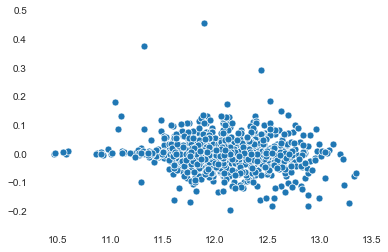

In [218]:
pred1=pred.detach().numpy()
pred1=[y[0] for y in pred1]
y1=y.detach().numpy()
y1=[y[0] for y in y1]
diff=[]
for i in range(len(pred1)):
    diff.append(pred1[i]-y1[i])
sns.scatterplot(y1,diff)

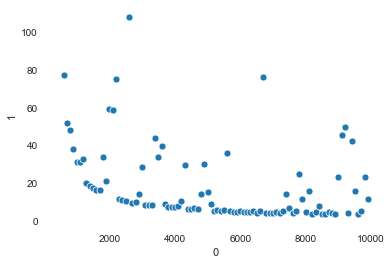

In [184]:
#
train_loss.pop(0)
a=pd.DataFrame(test_loss)
b=pd.DataFrame(train_loss)
#a.columns
sns.scatterplot(b[0],b[1])


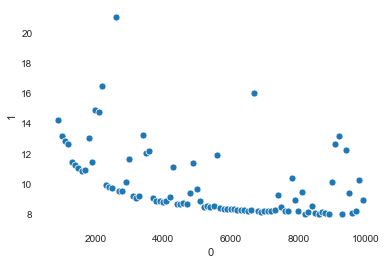

In [185]:
#test_loss.pop(0)
a=pd.DataFrame(test_loss)
sns.scatterplot(a[0],a[1])

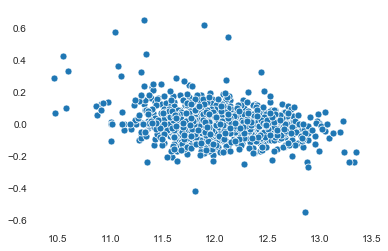

In [176]:
#plot residuals
#residualPlot(linReg.predict(X_train_),Y_train_)
#residualPlot(np.exp(linRegLog.predict(X_train_)),Y_train_)

#X_train_1,X_test_1,test_orig_processed1 = remove_corr(X_train_,X_test_,test_orig_processed)
#X_train_2,Y_train_2=removeYOutliers(X_train_1,Y_train_)
#X_train_3,Y_train_3=removeOutliersX(X_train_2,Y_train_2)
#residualPlot(olsLog1.predict(X_train_3),np.log(Y_train_3))
#residualPlot(rf.predict(X_train_2),np.log(Y_train_2))

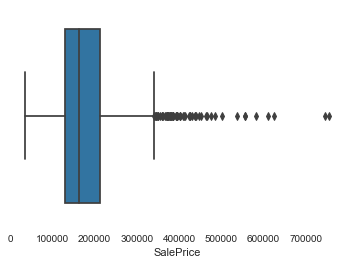

In [143]:
#boxplot
sns.boxplot(x=Y_train)


In [ ]:
olsLog.summary()

In [ ]:
olsLog.pvalues>0.05

In [258]:
avg=np.average(Y_train_)
std=np.std(Y_train_)
indexes = np.array((np.where(Y_train_ > avg+4*std)))[0]
a =[y for y in Y_train_ if y > avg+4*std]
a=pd.Series(a)
b=X_train_.loc[indexes,:]


In [299]:
y=np.log(Y_train_)
avg=np.average(y)
std=np.std(y)
orig_index=y[y.loc[:]<=avg+4*std].index
indexes = np.array(orig_index)
a =[y for y in y if y <= avg+4*std]
a=pd.Series(a,orig_index)
b=X_train_.loc[indexes,:]
print(b.index)
a.index==b.index
print(y[y.loc[:]>avg+4*std].index)

Int64Index([ 728,  846,  360,    4,  678,  558,   34, 1025,  549, 1105,
            ...
            1094,  599,  277, 1033, 1383,  763,  835, 1216,  559,  684],
           dtype='int64', length=1430)
Int64Index([], dtype='int64')
